In [2]:
# import libraries for API requests
import datetime
from datetime import date, timedelta
import requests
import json
import pandas as pd

# import libraries for regex, wordcloud and counter
import re
from unidecode import unidecode
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

# import libraries for sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pysentimiento import create_analyzer
from pysentimiento.preprocessing import preprocess_tweet
from sentiment_analysis_spanish import sentiment_analysis


In [ ]:
# Define
video_key = ''
video_host = ''
comments_key = ''
comments_host = ''
video_ids = []

In [12]:
# TikTok RapidAPI
# RapidAPI video info request
video_url = "https://video-nwm.p.rapidapi.com/url/"

video_headers = {
	"X-RapidAPI-Key": video_key,
	"X-RapidAPI-Host": video_host
}

video_df = pd.DataFrame()

# Get response for each video ID
for i in range(len(video_ids)):
	# Video request
	video_querystring = {"url":url+video_ids[i]}
	video_info = requests.request("GET", video_url, headers=video_headers, params=video_querystring)
	print(video_info)
	if video_info.status_code != 200:
		print("Error in video request")
	else:
		try: 
			video_info.json()['item']
			# Video response to dataframe
			video_statistics = pd.json_normalize(video_info.json()['item']['stats'])
			video_statistics['create_time'] = video_info.json()['item']['createTime']
			video_statistics['desc'] = video_info.json()['item']['desc']
			video_statistics['duration'] = video_info.json()['item']['video']['duration']
			video_statistics['owner'] = video_info.json()['item']['author']['nickname']
			# Video concat results in dataframe
			video_df = pd.concat([video_df,video_statistics])
		except Exception as e:
			print(e)
			print(video_info.json())
			pass


<Response [200]>
'item'
{'status': '1', 'msg': 'Private videos'}


In [5]:
# RapidAPI comments request
comments_url = "https://video-nwm.p.rapidapi.com/comment/"

comments_headers = {
	"X-RapidAPI-Key": comments_key,
	"X-RapidAPI-Host": comments_host
}

comments_df = pd.DataFrame()

# Get response for each video ID
for i in range(len(video_ids)):
	# Comments request
	comments_querystring = {"aweme_id":video_ids[i],"cursor":"0"}
	comments = requests.request("GET", comments_url, headers=comments_headers, params=comments_querystring)
	print(comments)
	if comments.status_code != 200:
		print("Error in comments request")
	else:
		try:
			# Comments response to dataframe
			commentsjson = pd.json_normalize(comments.json()['comments'])
			commentsjson['aweme_id']=video_id[i]
			# Comments concat results in dataframe
			comments_df = pd.concat([comments_df,commentsjson])
		except Exception as e:
			print(e)
			print(comments.json())
			pass

<Response [200]>


In [22]:
# Format create time
video_df['create_time'] = video_df['create_time'].apply(lambda val: datetime.datetime.fromtimestamp(val))
print(str(comments_df.ndim) + "\n" + str(comments_df.size) + "\n" + str(comments_df.shape))

2
22201
(149, 149)


C:\Users\jorge.melendez\AppData\Local\Temp\ipykernel_24196\977387801.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  comments_df['text']


Number of tokens = 218

[('vale', 3), ('quiero', 3), ('opto', 2), ('carisimo', 2), ('bro', 2)]


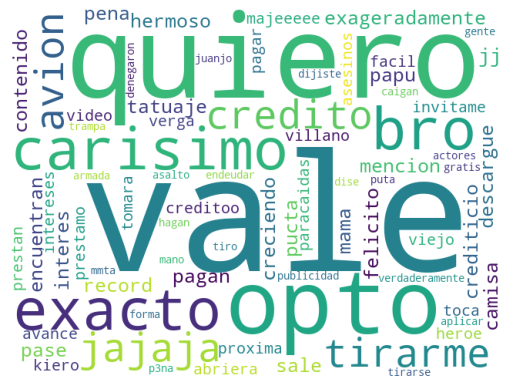

In [6]:
# ANALYZE COMMENTS
# Cleaning characters
text_clean = (
    comments_df['text']
    .str.replace(r'\n', ' ')
    .str.replace(r'\[.*?\]', '')
    .str.replace(r'\u2005', ' ')
    .str.replace(r'\u205f', ' ')
    .str.replace(r'[(),-]', ' ')
    .str.replace(r'\s+', ' ')
    .str.strip()
    .str.lower()
)
# join all comments into a string
text = " ".join(text_clean)
# cleaning accented words
text = unidecode(text)

# Perform tokenization
# the w+ allows us to capture the word as a whole, and giving us a much cleaner result compared to only using split()
# the r beside  \w+ here represents a raw string, it is a special requirements for regex
tokens = re.findall(r'\w+', text)
print("Number of tokens = "+"{:,}\n".format(len(tokens)))

# remove stop words and rank the top 50 high occurrence keywords
stopwords = open('stopwords_es.txt','r').read().splitlines()
tokens = [t.lower() for t in tokens if t.lower() not in stopwords]
print(Counter(tokens).most_common(5))

# create word cloud visualization
text_wordcloud = " ".join(tokens)
cloud = WordCloud(background_color="white", width=640, height=480, collocations = False).generate(text_wordcloud)

plt.imshow(cloud)
plt.axis("off")
plt.show()

cloud.to_file("wordcloud.png")

In [7]:
# SENTIMENT ANALYSIS 
# Using NLTK
# nltk.download("vader_lexicon") # download the lexicon
sid = SentimentIntensityAnalyzer()

# classify the comments
summary = {"positive":0,"neutral":0,"negative":0}
# compound summary by video ID
for sentence in text_clean: 
    ss = sid.polarity_scores(sentence)
    if ss["compound"] == 0.0: 
        summary["neutral"] +=1
    elif ss["compound"] > 0.0:
        summary["positive"] +=1
    else:
        summary["negative"] +=1

# create dataframes with columns
sa_nltk = pd.DataFrame(columns=['sentence','output','POS','NEU','NEG'])
sa1_df = pd.DataFrame(columns=['sentence','output','POS','NEU','NEG'],index=range(1))
# concat results in dataframe
for sentence in text_clean:
    sa1_df['sentence'] = sentence
    sa1_df['output'] = sid.polarity_scores(sentence)['compound']
    sa1_df['POS'] = sid.polarity_scores(sentence)['pos']
    sa1_df['NEU'] = sid.polarity_scores(sentence)['neu']
    sa1_df['NEG'] = sid.polarity_scores(sentence)['neg']
    sa_nltk = pd.concat([sa_nltk,sa1_df])


In [8]:
# Using pysentimiento
# sentiment and emotion analysis
analyzer = create_analyzer(task="sentiment", lang="es")
emotion_analyzer = create_analyzer(task="emotion", lang="es")

# create sentiment dataframes with columns
sa_pys = pd.DataFrame(columns=['output','POS','NEU','NEG'])
sa2_df = pd.DataFrame(columns=['output','POS','NEU','NEG'],index=range(1))
# create emotion dataframe with columns
ea_pys = pd.DataFrame(columns=['output','emotion'])
ea1_df = pd.DataFrame(columns=['output','emotion'],index=range(1))

# concat results in dataframe
for sentence in text_clean: 
    # cleaning comments
    sentence = preprocess_tweet(sentence)
    # sentiment analysis
    sa2_df['output'] = analyzer.predict(sentence).output
    sa2_df['POS'] = analyzer.predict(sentence).probas['POS']
    sa2_df['NEU'] = analyzer.predict(sentence).probas['NEU']
    sa2_df['NEG'] = analyzer.predict(sentence).probas['NEG']
    sa_pys = pd.concat([sa_pys,sa2_df])
    # emotion analysis
    ea1_df['output'] = emotion_analyzer.predict(sentence).output
    ea1_df.loc[sentence,'emotion'] = [emotion_analyzer.predict(sentence).probas]
    ea_pys = pd.concat([ea_pys,ea1_df])


loading configuration file config.json from cache at C:\Users\jorge.melendez/.cache\huggingface\hub\models--pysentimiento--robertuito-emotion-analysis\snapshots\bcd6835f4d1ab1a061bd7437c9d762623c8437ad\config.json
Model config RobertaConfig {
  "_name_or_path": "pysentimiento/robertuito-emotion-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "others",
    "1": "joy",
    "2": "sadness",
    "3": "anger",
    "4": "surprise",
    "5": "disgust",
    "6": "fear"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "disgust": 5,
    "fear": 6,
    "joy": 1,
    "others": 0,
    "sadness": 2,
    "surprise": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 130,

In [9]:
# Using sentiment-spanish
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
# create dataframe with columns
sa_sen = pd.DataFrame(columns=['sentiment'])
sa3_df = pd.DataFrame(columns=['sentiment'],index=range(1))

# concat results in dataframe
for sentence in text_clean: 
    sa3_df['sentiment'] = sentiment.sentiment(sentence)
    sa_sen = pd.concat([sa_sen,sa3_df])

c:\Users\jorge.melendez\Miniconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\jorge.melendez\Miniconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
#SAVE DATAFRAMES AS CSV
comments_sa = pd.concat([comments_df['aweme_id'].reset_index(drop=True),sa_nltk.reset_index(drop=True),sa_pys.reset_index(drop=True),sa_sen.reset_index(drop=True)], axis=1)
comments_sa.to_csv("TikTok_sentiment.csv", index=False)
comments_sa

,aweme_id,sentence,output,POS,NEU,NEG,output,POS,NEU,NEG,sentiment
0,7217993536770149638,opto carisimo bro pero exageradamente carisimo...,-0.2960,0.000,0.905,0.095,NEG,0.003367,0.058698,0.937935,0.000003
1,7217993536770149638,exacto mi mamá tiene récord créditicio y ni as...,0.0000,0.000,1.000,0.000,NEG,0.010151,0.155252,0.834597,0.002513
2,7217993536770149638,quiero saber más sobre lo de opto,0.0000,0.000,1.000,0.000,NEU,0.060560,0.862144,0.077296,0.023384
3,7217993536770149638,pucta que hermoso,0.0000,0.000,1.000,0.000,POS,0.841720,0.115731,0.042549,0.767953
4,7217993536770149638,yo lo descargue y no sale nada,-0.2960,0.000,0.694,0.306,NEG,0.015937,0.429520,0.554543,0.007460
5,7217993536770149638,😁😅,0.0000,0.000,1.000,0.000,NEU,0.085061,0.795055,0.119884,0.497892
6,7217993536770149638,por que no me encuentran a mi para eso 😭,-0.2960,0.000,0.761,0.239,NEG,0.003041,0.034908,0.962052,0.000060
7,7217993536770149638,😂😂 yo tengo el tatuaje de tu camisa 😅😅😅,0.0000,0.000,1.000,0.000,NEU,0.075694,0.660084,0.264222,0.030467
8,7217993536770149638,que no te pase😂,-0.2960,0.000,0.577,0.423,NEU,0.066017,0.679828,0.254155,0.002449
9,7217993536770149638,te felicito jj estas creciendo en contenido pa...,0.2500,0.222,0.778,0.000,POS,0.976251,0.019816,0.003934,0.177854


# Paid Campaigns API

In [ ]:
# TikTok Official API
def get_tiktok_data(access_token):
    request_url = 'https://business-api.tiktok.com/open_api/v1.2/reports/integrated/get/'
    headers = {
        'access-token': access_token,
        'content_type': 'application/json'
    }
    metrics = [
        'campaign_name', 'spend', 'cpc', 'cpm', 'impressions', 'clicks', 'ctr', 'reach', 'cost_per_1000_reached', 'conversion', 'conversion_rate', 'currency', 'sales_lead', 'total_sales_lead_value', 'skan_sales_lead'
    ]
    dimensions = [
        'campaign_id',
    ]
    date_from = date.today().replace(day=1)
    date_to = (date_from + timedelta(days=32)).replace(day=1) - timedelta(days=1)
    data = {
        'advertiser_id': client.int_id,
        'data_level': 'AUCTION_CAMPAIGN',
        'report_type': 'BASIC',
        'dimensions': json.dumps(dimensions),
        'metrics': json.dumps(metrics),
        'start_date': date_from,
        'end_date': date_to,
        'lifetime': 'false',
        'page_size': 1000,
    }
    resp = requests.get(request_url, headers=headers, data=data)
    result = resp.json()
    print(result)
    return result 